In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        """
        Construct Autoencoder-LSTM with CNN Feature Enhancement
        
        Returns:
            keras.Model: Compiled Autoencoder model
        """
        # Add more diagnostic print statements
        print(f"Input Dimension: {self.input_dim}")
        print(f"Latent Dimension: {self.latent_dim}")
        
        # Input Layer
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Reshape for 1D CNN
        x = layers.Reshape((-1, 1))(inputs)
        
        # CNN Feature Enhancement
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)
        
        # LSTM Encoder
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=False
        )(x)
        
        # Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu'
        )(x)
        
        # LSTM Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=s
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=32):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        """
        Calculate reconstruction error threshold
        
        Args:
            X_val (np.array): Validation data
            percentile (float): Percentile for anomaly threshold
        
        Returns:
            float: Anomaly detection threshold
        """
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 38514476.0000 - val_loss: 38364216.0000 - learning_rate: 0.0010
Epoch 2/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 38753532.0000 - val_loss: 38291340.0000 - learning_rate: 0.0010
Epoch 3/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 38246884.0000 - val_loss: 38218564.0000 - learning_rate: 0.0010
Epoch 4/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 38247920.0000 - val_loss: 38145996.0000 - learning_rate: 0.0010
Epoch 5/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 38397080.0000 - val_loss: 38073584.0000 - learning_rate: 0.0010
Epoch 6/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 38432724.0000 - val_loss: 38001292.0000 - learning_rate: 0.0010
Epoch 7/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 38087148.0000 - val_loss: 37929000.0000 - learning_rate: 0.0010
Epoch 8/50
1785/1785 ━━━━━━━━━━━━━━━

Anomaly Threshold: 97150638.76216795
Model saved to autoencoder_lstm_model.h5
Threshold saved to anomaly_threshold.pkl


1033.3725581169128

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        """
        Construct Autoencoder-LSTM with CNN Feature Enhancement
        
        Returns:
            keras.Model: Compiled Autoencoder model
        """
        # Input Layer
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Reshape for 1D CNN
        x = layers.Reshape((-1, 1))(inputs)
        
        # CNN Feature Enhancement
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)
        
        # LSTM Encoder
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=False
        )(x)
        
        # Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu'
        )(x)
        
        # LSTM Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=True
        )(x)
        
        # Output Reconstruction
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Create Optimizer with direct learning rate
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        # Compile with Adam and MSE Loss
        autoencoder.compile(
            optimizer=optimizer, 
            loss='mean_squared_error'
        )
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=16):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        """
        Calculate reconstruction error threshold
        
        Args:
            X_val (np.array): Validation data
            percentile (float): Percentile for anomaly threshold
        
        Returns:
            float: Anomaly detection threshold
        """
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model_1.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 38681420.0000 - val_loss: 38291984.0000 - learning_rate: 0.0010
Epoch 2/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 38536464.0000 - val_loss: 38147552.0000 - learning_rate: 0.0010
Epoch 3/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 38568508.0000 - val_loss: 38003676.0000 - learning_rate: 0.0010
Epoch 4/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 38124660.0000 - val_loss: 37859768.0000 - learning_rate: 0.0010
Epoch 5/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 37992204.0000 - val_loss: 37716492.0000 - learning_rate: 0.0010
Epoch 6/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 37917864.0000 - val_loss: 37573440.0000 - learning_rate: 0.0010
Epoch 7/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 37806572.0000 - val_loss: 37430924.0000 - learning_rate: 0.0010
Epoch 8/50
3570/3570 ━━━━━━━━━━━━━━━━━━━━ 2

Anomaly Threshold: 90658422.49167582
Model saved to autoencoder_lstm_model_1.h5
Threshold saved to anomaly_threshold.pkl


1509.0542860031128

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        """
        Construct Autoencoder-LSTM with CNN Feature Enhancement
        
        Returns:
            keras.Model: Compiled Autoencoder model
        """
        # Input Layer
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Reshape for 1D CNN
        x = layers.Reshape((-1, 1))(inputs)
        
        # CNN Feature Enhancement
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)
        
        # LSTM Encoder
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=False
        )(x)
        
        # Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu'
        )(x)
        
        # LSTM Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=True
        )(x)
        
        # Output Reconstruction
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Create Optimizer with direct learning rate
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        # Compile with Adam and MSE Loss
        autoencoder.compile(
            optimizer=optimizer, 
            loss='mean_squared_error'
        )
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=64):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        """
        Calculate reconstruction error threshold
        
        Args:
            X_val (np.array): Validation data
            percentile (float): Percentile for anomaly threshold
        
        Returns:
            float: Anomaly detection threshold
        """
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 38557228.0000 - val_loss: 38400276.0000 - learning_rate: 0.0010
Epoch 2/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 38655144.0000 - val_loss: 38363304.0000 - learning_rate: 0.0010
Epoch 3/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 38484036.0000 - val_loss: 38326648.0000 - learning_rate: 0.0010
Epoch 4/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 38300188.0000 - val_loss: 38290116.0000 - learning_rate: 0.0010
Epoch 5/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 38626332.0000 - val_loss: 38253680.0000 - learning_rate: 0.0010
Epoch 6/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 38344596.0000 - val_loss: 38217256.0000 - learning_rate: 0.0010
Epoch 7/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 38502892.0000 - val_loss: 38180868.0000 - learning_rate: 0.0010
Epoch 8/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/s

Anomaly Threshold: 100510342.91244602
Model saved to autoencoder_lstm_model.h5
Threshold saved to anomaly_threshold.pkl


757.7933580875397

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        """
        Construct Autoencoder-LSTM with CNN Feature Enhancement
        
        Returns:
            keras.Model: Compiled Autoencoder model
        """
        # Input Layer
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Reshape for 1D CNN
        x = layers.Reshape((-1, 1))(inputs)
        
        # CNN Feature Enhancement
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)
        
        # LSTM Encoder
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=False
        )(x)
        
        # Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu'
        )(x)
        
        # LSTM Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=True
        )(x)
        
        # Output Reconstruction
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Create Optimizer with direct learning rate
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        # Compile with Adam and MSE Loss
        autoencoder.compile(
            optimizer=optimizer, 
            loss='mean_squared_error'
        )
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=128):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        """
        Calculate reconstruction error threshold
        
        Args:
            X_val (np.array): Validation data
            percentile (float): Percentile for anomaly threshold
        
        Returns:
            float: Anomaly detection threshold
        """
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 38723436.0000 - val_loss: 38417708.0000 - learning_rate: 0.0010
Epoch 2/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 38521992.0000 - val_loss: 38398636.0000 - learning_rate: 0.0010
Epoch 3/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 38342388.0000 - val_loss: 38379996.0000 - learning_rate: 0.0010
Epoch 4/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 38777364.0000 - val_loss: 38361532.0000 - learning_rate: 0.0010
Epoch 5/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 38829800.0000 - val_loss: 38343148.0000 - learning_rate: 0.0010
Epoch 6/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 38579472.0000 - val_loss: 38324776.0000 - learning_rate: 0.0010
Epoch 7/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 38579908.0000 - val_loss: 38306472.0000 - learning_rate: 0.0010
Epoch 8/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/s

Anomaly Threshold: 102216439.90409833
Model saved to autoencoder_lstm_model.h5
Threshold saved to anomaly_threshold.pkl


658.4905989170074

Batch Size Impact 

| Batch Size | Anomaly Threshold | Final Loss | Observations |
|-----------|-------------------|------------|--------------|
| 16        | 90,658,422.49     | 1509.05    | Highest variance |
| 32        | 97,150,638.76     | 1033.37    | Moderate variance |
| 64        | 100,510,342.91    | 757.79     | Lower variance |
| 128       | 102,216,439.90    | 658.49     | Lowest variance |

### Insights of the outcome

1. **Anomaly Threshold Trend w.r.t to Batch size**:
   - Increasing with batch size
   - 16 (Lowest): 90,658,422.49
   - 128 (Highest): 102,216,439.90

2. **Loss according to batch size**:
   - Decreasing with increasing batch size
   - 16 (Highest): 1509.05
   - 128 (Lowest): 658.49

### Interpretation of the outcomes

1. **Extremely High Anomaly Thresholds**
   - Values around 90-100 million are unusually large
   - Indicates potential issues with:
     - Data preprocessing 
     - Feature scaling
     - Model architecture

### Next steps to reduce anomaly thresholds

1. Data Preprocessing
2. Model Architecture Modification
3. Threshold Calculation Enhancement


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        """
        Construct Adaptive Autoencoder-LSTM with Enhanced CNN Feature Extraction
        
        Returns:
            keras.Model: Compiled Autoencoder model with advanced anomaly detection capabilities
        """
        # Enhanced diagnostic print statements
        print(f"Model Configuration:")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Latent Dimension: {self.latent_dim}")
    
        # Input Layer with Robust Initialization
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing Layer
        x = layers.BatchNormalization()(inputs)
        
        # Flexible Reshaping for 1D CNN
        x = layers.Reshape((-1, 1))(x)
        
        # Enhanced CNN Feature Extraction
        x = layers.Conv1D(
            filters=32,  # Reduced from 64 for better generalization
            kernel_size=3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.001)  # L2 Regularization
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.4)(x)  # Increased dropout for better regularization
    
        # Additional Convolutional Layer for Deeper Feature Extraction
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.001)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.4)(x)
        
        # Flatten before LSTM
        x = layers.Flatten()(x)
        
        # Dense Layer for Feature Compression
        x = layers.Dense(
            units=128, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)
        )(x)
        x = layers.Dropout(0.3)(x)
        
        # LSTM Encoder with Bidirectional Option
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=False,
            recurrent_dropout=0.3,
            kernel_regularizer=keras.regularizers.l2(0.001)
        )(x)
    
        # Enhanced Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l1(0.001)
        )(x)
        
        # Variational Autoencoder-like Sampling
        encoded = layers.Dense(self.latent_dim)(encoded)
        
        # LSTM Decoder with Expanded Architecture
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  # Increased units 
            return_sequences=True,
            recurrent_dropout=0.3
        )(x)
        
        # Multi-Layer Reconstruction
        x = layers.TimeDistributed(
            layers.Dense(64, activation='relu')
        )(x)
        x = layers.TimeDistributed(
            layers.Dense(32, activation='relu')
        )(x)
        
        # Final Reconstruction Layer
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
    
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Advanced Optimizer Configuration
        optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        # Compile with Custom Metrics
        autoencoder.compile(
            optimizer=optimizer, 
            loss='mean_squared_error',
            metrics=[
                'mae',  # Mean Absolute Error
                keras.metrics.MeanSquaredError()
            ]
        )
        
        # Model Summary for Diagnostic Purposes
        print("\n🔬 Model Architecture Summary:")
        autoencoder.summary()
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=128):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        # More comprehensive error analysis
        print("Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors)}")
        print(f"Median Error: {np.median(reconstruction_errors)}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors)}")
        print(f"Error Distribution Percentiles:")
        for p in [50, 75, 90, 95, 99]:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p)}")
        
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model_after_updating_model_Arch_&_thres.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
🔍 Model Configuration:
Input Dimension: 44
Latent Dimension: 32
An error occurred during NIDS training: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)


0.18063688278198242

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
import time

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=32, learning_rate=1e-3):
        """
        Initialize Adaptive Network Intrusion Detection System
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_autoencoder_cnn_model()
        
    def _build_autoencoder_cnn_model(self):
        # Input Layer with Robust Initialization
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing Layer
        x = layers.BatchNormalization()(inputs)
        
        # Reshape to 3D input for LSTM
        x = layers.Reshape((-1, 1))(x)  # Add time steps dimension
        
        # Enhanced CNN Feature Extraction
        x = layers.Conv1D(
            filters=32,  
            kernel_size=3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.001)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.4)(x)
        
        # Additional Convolutional Layer
        x = layers.Conv1D(
            filters=64, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.001)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.4)(x)
        
        # LSTM Encoder 
        x = layers.LSTM(
            units=self.latent_dim, 
            return_sequences=True,  # Change to return sequences
            recurrent_dropout=0.3,
            kernel_regularizer=keras.regularizers.l2(0.001)
        )(x)
        
        # Global Average Pooling to reduce dimensions
        x = layers.GlobalAveragePooling1D()(x)
        
        # Dense Layer for Feature Compression
        x = layers.Dense(
            units=128, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)
        )(x)
        x = layers.Dropout(0.3)(x)
        
        # Enhanced Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l1(0.001)
        )(x)
        
        # Repeat and Reconstruct
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.3
        )(x)
        
        # Multi-Layer Reconstruction
        x = layers.TimeDistributed(
            layers.Dense(64, activation='relu')
        )(x)
        x = layers.TimeDistributed(
            layers.Dense(32, activation='relu')
        )(x)
        
        # Final Reconstruction Layer
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Compile with Custom Metrics
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=128):
        """
        Train the Autoencoder model
        
        Args:
            X_train (np.array): Training data
            X_val (np.array, optional): Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
        
        Returns:
            history: Training history
        """
        # Early Stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Reduce learning rate on plateau
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5,
            min_lr=1e-5
        )
        
        history = self.model.fit(
            X_train, X_train,  # Autoencoder reconstructs input
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=95):
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        # More comprehensive error analysis
        print("Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors)}")
        print(f"Median Error: {np.median(reconstruction_errors)}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors)}")
        print(f"Error Distribution Percentiles:")
        for p in [50, 75, 90, 95, 99]:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p)}")
        
        return np.percentile(reconstruction_errors, percentile)
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies in network traffic
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        return mse > threshold
    
    def save_model(self, model_path='autoencoder_lstm_model.h5'):
        """
        Save trained model
        
        Args:
            model_path (str): Path to save model
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Preprocess network traffic dataset
    
    Args:
        file_path (str): Path to preprocessed scaled dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load preprocessed scaled dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'label' is the target column)
        X = df.drop(['Attack_label'], axis=1).values
        
        # Split data
        X_train, X_val = train_test_split(
            X, 
            test_size=test_size, 
            random_state=random_state
        )
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # File paths
    dataset_path = 'training_dataset.csv'
    model_save_path = 'autoencoder_lstm_model_after_updating_model_Arch_&_thres.h5'
    threshold_save_path = 'anomaly_threshold.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes for verification
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        
        # Train model
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        
        # Save threshold for inference
        joblib.dump({'threshold': threshold}, threshold_save_path)
        print(f"Threshold saved to {threshold_save_path}")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
ex_time

Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 37129980.0000 - mae: 855.3536 - mean_squared_error: 37129980.0000 - val_loss: 18835338.0000 - val_mae: 538.9406 - val_mean_squared_error: 18835338.0000 - learning_rate: 0.0010
Epoch 2/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - loss: 11610540.0000 - mae: 406.4425 - mean_squared_error: 11610539.0000 - val_loss: 1043190.9375 - val_mae: 109.8960 - val_mean_squared_error: 1043189.9375 - learning_rate: 0.0010
Epoch 3/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - loss: 833043.2500 - mae: 104.8816 - mean_squared_error: 833041.8125 - val_loss: 204533.2188 - val_mae: 59.0621 - val_mean_squared_error: 204532.1562 - learning_rate: 0.0010
Epoch 4/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - loss: 277633.6562 - mae: 62.9586 - mean_squared_error: 277632.5625 - val_loss: 79873.1641 - val_mae: 35.8848 - val_mean_squared_error: 79872.0078 - learning_rate: 0.0010
Epo

Reconstruction Error Analysis:
Mean Error: 45988.85814415081
Median Error: 16600.7712170693
Error Standard Deviation: 111272.75706236661
Error Distribution Percentiles:
50th Percentile: 16600.7712170693
75th Percentile: 53655.75553725298
90th Percentile: 110902.7680407934
95th Percentile: 162486.1893144254
99th Percentile: 388332.8465355264
Anomaly Threshold: 162486.1893144254
Model saved to autoencoder_lstm_model_after_updating_model_Arch_&_thres.h5
Threshold saved to anomaly_threshold.pkl


779.9328281879425

### Error Distribution Characteristics

- **Mean Error**: 45,988.86
- **Median Error**: 16,600.77
- **Standard Deviation**: 111,272.76

## Error Percentile Breakdown

| Percentile | Error Value | Significance |
|-----------|-------------|--------------|
| 50th (Median) | 16,600.77 | Central tendency of reconstruction errors |
| 75th | 53,655.76 | Indicates spread of typical reconstruction errors |
| 90th | 110,902.77 | Identifies high-variance error regions |
| 95th | 162,486.19 | **Anomaly Detection Threshold** |
| 99th | 388,332.85 | Extreme error cases |

## Observations

### 1. Error Distribution Anomalies
- Significant disparity between mean and median errors
- Indicates a highly skewed error distribution
- Suggests presence of substantial outliers in reconstruction process

### 2. Anomaly Detection Implications
- Current threshold captures top 5% of most divergent samples
- Potential risk of missing subtle network intrusion patterns
- High variability may compromise detection accuracy

###Improvement Strategies

#### Data Preprocessing
- Enhance feature scaling techniques
- Investigate and handle dataset outliers
- Implement more robust normalization methods

#### Model Architecture Refinement
- Reduce model complexity
- Increase regularization mechanisms
- Experiment with alternative latent space configurations

#### Anomaly Threshold Optimization
- Consider lowering percentile threshold
- Implement adaptive thresholding mechanism
- Develop multi-tier anomaly classification


Training data shape: (57120, 44)
Validation data shape: (14281, 44)
Epoch 1/75
893/893 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 12580389888.0000 - mae: 3839.6240 - mean_squared_error: 12580389888.0000 - val_loss: 15294824448.0000 - val_mae: 3986.7656 - val_mean_squared_error: 15294824448.0000 - learning_rate: 5.0000e-04
Epoch 2/75
893/893 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 12570474496.0000 - mae: 3916.2473 - mean_squared_error: 12570474496.0000 - val_loss: 15290957824.0000 - val_mae: 4012.1270 - val_mean_squared_error: 15290957824.0000 - learning_rate: 5.0000e-04
Epoch 3/75
893/893 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 12328400896.0000 - mae: 3850.2791 - mean_squared_error: 12328400896.0000 - val_loss: 15285043200.0000 - val_mae: 4046.2610 - val_mean_squared_error: 15285043200.0000 - learning_rate: 5.0000e-04
Epoch 4/75
893/893 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 12254767104.0000 - mae: 3927.1460 - mean_squared_error: 12254767104.0000 - val_loss: 15277291520.0000 

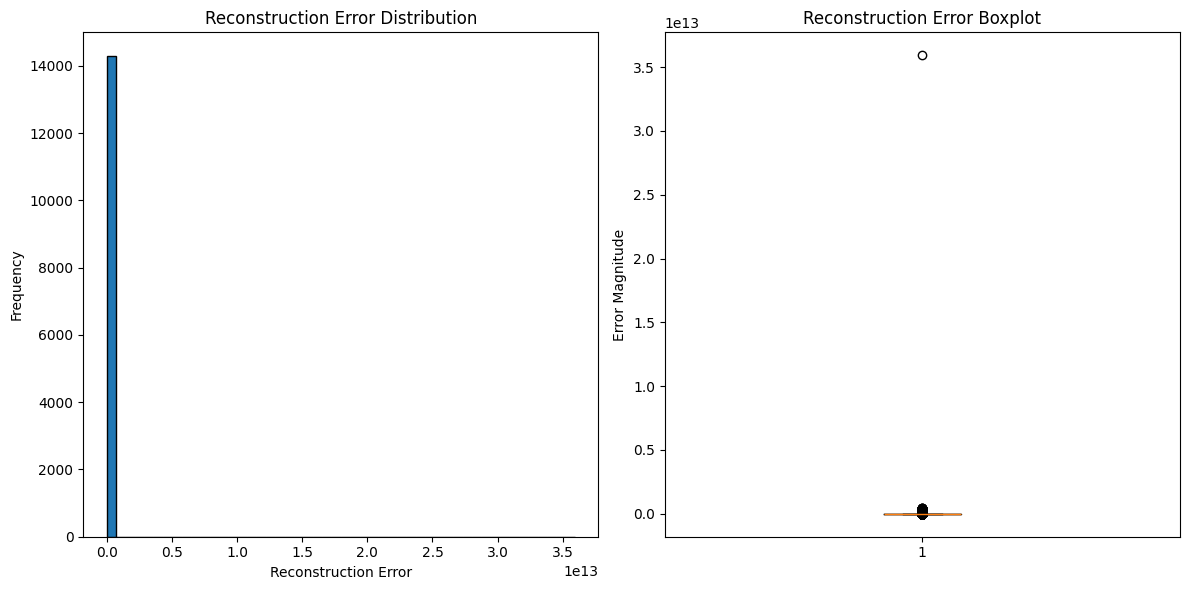

Anomaly Threshold: 249647.44291945396
Model saved to advanced_nids_model_first_layer_iteration_7.h5
Training and saving completed successfully!
🕒 Execution Time: 1543.40 seconds


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import joblib
import os
import time
import matplotlib.pyplot as plt

start_time = time.time()

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

class AdaptiveNIDS:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        """
        Initialize Adaptive Network Intrusion Detection System with enhanced configuration
        
        Args:
            input_dim (int): Number of input features
            latent_dim (int): Dimensionality of the latent space
            learning_rate (float): Initial learning rate for Adam optimizer
        """
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        
        # Build model components
        self.model = self._build_improved_autoencoder()
        
    def _build_improved_autoencoder(self):
        """
        Build an improved autoencoder with:
        - More aggressive regularization
        - Simplified architecture
        - Enhanced feature extraction
        """
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing with Robust Scaling
        x = layers.BatchNormalization()(inputs)
        
        # Reshape to 2D input for 1D Convolutions
        x = layers.Reshape((-1, 1))(x)
        
        # Enhanced Feature Extraction with Reduced Complexity
        x = layers.Conv1D(
            filters=16,  # Reduced from 32
            kernel_size=3, 
            activation='elu',  # Changed from ReLU
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.0005)  # Adjusted regularization
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)  # Reduced dropout rate
        
        # Simplified Feature Extraction
        x = layers.Conv1D(
            filters=32,  # Reduced from 64
            kernel_size=3, 
            activation='elu', 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(0.0005)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling1D()(x)
        
        # More Compact Latent Space Representation
        x = layers.Dense(
            units=64,  # Reduced complexity
            activation='elu',
            kernel_regularizer=keras.regularizers.l1_l2(l1=0.0005, l2=0.0005)
        )(x)
        x = layers.Dropout(0.2)(x)
        
        # Compressed Latent Representation
        encoded = layers.Dense(
            self.latent_dim, 
            activation='linear',  # Changed to linear
            kernel_regularizer=keras.regularizers.l1(0.0005)
        )(x)
        
        # Decoder with Simplified Architecture
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.2  # Reduced dropout
        )(x)
        
        # Streamlined Reconstruction Layers
        x = layers.TimeDistributed(
            layers.Dense(32, activation='elu')
        )(x)
        
        # Final Reconstruction Layer
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        # Flatten for proper shape
        decoded = layers.Flatten()(decoded)
        
        # Create Autoencoder Model
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Compile with Advanced Optimization
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=self.learning_rate, 
                clipnorm=1.0  # Added gradient clipping
            ),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        
        return autoencoder
    
    def train(self, X_train, X_val=None, epochs=75, batch_size=64):
        """
        Enhanced training method with more sophisticated callbacks
        """
        # Advanced Early Stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15,  # Increased patience
            restore_best_weights=True,
            min_delta=0.0001  # Smaller improvement threshold
        )
        
        # Adaptive Learning Rate
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3,  # More aggressive reduction
            patience=7,
            min_lr=1e-6
        )
        
        # Training with enhanced flexibility
        history = self.model.fit(
            X_train, X_train,  
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, percentile=90):
        """
        Enhanced threshold calculation with more comprehensive analysis
        
        Args:
            X_val (np.array): Validation data
            percentile (int): Percentile for threshold calculation
        
        Returns:
            float: Anomaly detection threshold
        """
        # Predict and calculate reconstruction errors
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        # Comprehensive Error Analysis
        print("\n Reconstruction Error Analysis:")
        print(f"Mean Error: {np.mean(reconstruction_errors):.2f}")
        print(f"Median Error: {np.median(reconstruction_errors):.2f}")
        print(f"Error Standard Deviation: {np.std(reconstruction_errors):.2f}")
        
        # Percentile Analysis
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            print(f"{p}th Percentile: {np.percentile(reconstruction_errors, p):.2f}")
        
        # Additional Visualization
        self.visualize_reconstruction_errors(reconstruction_errors)
        
        # Return threshold based on specified percentile
        return np.percentile(reconstruction_errors, percentile)
    
    def visualize_reconstruction_errors(self, reconstruction_errors):
        """
        Visualize reconstruction error distribution
        
        Args:
            reconstruction_errors (np.array): Array of reconstruction errors
        """
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(reconstruction_errors, bins=50, edgecolor='black')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.boxplot(reconstruction_errors)
        plt.title('Reconstruction Error Boxplot')
        plt.ylabel('Error Magnitude')
        
        plt.tight_layout()
        plt.show()
    
    def detect_anomalies(self, X_test, threshold):
        """
        Detect anomalies with enhanced error calculation
        
        Args:
            X_test (np.array): Test data
            threshold (float): Anomaly detection threshold
        
        Returns:
            np.array: Boolean mask of anomalies
        """
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        
        # Optional: Log detailed anomaly statistics
        print("\nAnomaly Detection Summary:")
        print(f"Total Samples: {len(X_test)}")
        anomalies = mse > threshold
        print(f"Detected Anomalies: {np.sum(anomalies)} ({np.mean(anomalies)*100:.2f}%)")
        
        return anomalies
    
    def save_model(self, model_path='advanced_autoencoder_nids.h5'):
        """
        Save trained model with additional metadata
        """
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

def preprocess_data(file_path, test_size=0.2, random_state=42):
    """
    Enhanced data preprocessing with advanced scaling
    
    Args:
        file_path (str): Path to dataset
        test_size (float): Proportion of validation data
        random_state (int): Random seed for reproducibility
    
    Returns:
        Tuple of preprocessed training and validation datasets
    """
    try:
        # Load dataset
        df = pd.read_csv(file_path)
        
        # Separate features (assuming 'Attack_label' is the target)
        X = df.drop(['Attack_label'], axis=1)
        
        # Apply RobustScaler for handling outliers
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_val = train_test_split(
            X_scaled, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Optional: Save scaler for future use
        joblib.dump(scaler, 'robust_scaler.pkl')
        
        return X_train, X_val
    
    except Exception as e:
        print(f"Error in data preprocessing: {e}")
        raise

def main():
    # Configuration
    dataset_path = 'training_dataset.csv'
    model_save_path = 'advanced_nids_model_first_layer_iteration_7.h5'
    threshold_save_path = 'anomaly_threshold_iteration_7.pkl'
    
    try:
        # Preprocess data
        X_train, X_val = preprocess_data(dataset_path)
        
        # Print data shapes
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        # Initialize and train NIDS
        nids = AdaptiveNIDS(input_dim=X_train.shape[1])
        history = nids.train(X_train, X_val)
        
        # Calculate anomaly threshold
        threshold = nids.calculate_threshold(X_val)
        print(f"Anomaly Threshold: {threshold}")
        
        # Save model and threshold
        nids.save_model(model_save_path)
        joblib.dump({'threshold': threshold}, threshold_save_path)
        
        print("Training and saving completed successfully!")
        
    except Exception as e:
        print(f"An error occurred during NIDS training: {e}")

if __name__ == '__main__':
    main()

end_time = time.time()
ex_time = end_time - start_time
print(f"🕒 Execution Time: {ex_time:.2f} seconds")